# Kaggle - LANL Earthquake Prediction - putting all together

## Import packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
# spectrogram with scipy
from scipy import signal
from IPython.display import clear_output

from tqdm import tqdm_notebook as tqdm
import gc

import glob, os, sys

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import model_from_json, Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, CuDNNGRU, Dropout, Dense
from tensorflow.keras.layers import Flatten, TimeDistributed, AveragePooling1D, Embedding, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('gpu name:',tf.test.gpu_device_name())


# Any results you write to the current directory are saved as output in
print(os.listdir("./data"))

input_dir = './data/train/'

#garbage collect
gc.collect()


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6901868902339892303
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1613458263000109487
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8606264122534619333
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10551502439
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9567790010695238454
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
gpu name: /device:GPU:0
['train', 'sample_submission.csv', 'test', 'train.csv', 'model', 'train.png', 'sample_submission_bkp.csv', 'test_miny.csv']


4

In [6]:
# SAFETY GUARD TO PREVENT FROM RUNNING BY MISTAKE
answer = input("Do you want to disable the gpu? ")
if answer != 'yes': sys.exit(0)

# EXCLUDE GPU (ONLY IF NEEDED!!!!)
sess_cpu = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
print('GPU disabled')

Do you want to disable the gpu? no


SystemExit: 0

/shome/perrozzi/.conda/envs/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Load the (huge) training data

In [9]:
# SAFETY GUARD TO PREVENT FROM RUNNING BY MISTAKE
answer = input("Do you want to load the training data? ")
if answer != 'yes': sys.exit(0)

%time
# %time
# limit the load to 10M lines for display purpose
# train = pd.read_csv('./data/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}, nrows=int(10e6)
# train = pd.read_csv('./data/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}, nrows=int(50e6))
train = pd.read_csv('./data/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
#Collect garbage
gc.collect()

print('training sample size',train.shape[0])

Do you want to load the training data? yes
CPU times: user 12 µs, sys: 2 µs, total: 14 µs
Wall time: 26 µs
training sample size 629145480


## Create spectrograms for training data

In [10]:
# SAFETY GUARD TO PREVENT FROM RUNNING BY MISTAKE
answer = input("Do you want to create spectrograms for training data? ")
if answer != 'yes': sys.exit(0)

# formula on number of segments from convolutional lectures: (n + 2p - f)/s + 1
rows = 150_000
stride = 5_000 # <------------- THE MOST IMPORTANT PARAMETER!!!
segments = int(np.floor((train.shape[0] - rows)/stride + 1))
print("number of segments:",segments)

plt.ioff()

for segment in tqdm(range(segments)):
    
    # if segment>2000: break
    
    seg_start = segment*stride
    seg_end = segment*stride+rows
    seg = train.iloc[seg_start:seg_end]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values
    #print(x,y)
    
    if os.path.isfile('./data/train/seg_start_'+str(seg_start)+'.png'): 
        # print('skipping file ./data/train/seg_start_'+str(seg_start)+'.png')
        continue
    

    fs = 1
    f, t, Sxx = signal.spectrogram(x, # array_like - Time series of measurement values
                               fs = fs, # float, optional - Sampling frequency of the x time series. Defaults to 1.0.
                               window = ('tukey', 0.25), # str or tuple or array_like, optional - Desired window to use. If window is a string or tuple, it is passed to get_window to generate the window values, which are DFT-even by default. See get_window for a list of windows and required parameters. If window is array_like it will be used directly as the window and its length must be nperseg. Defaults to a Tukey window with shape parameter of 0.25.
                               nperseg = 447, # int, optional - Length of each segment. Defaults to None, but if window is str or tuple, is set to 256, and if window is array_like, is set to the length of the window
                               noverlap = 113, # int, optional - Number of points to overlap between segments. If None, noverlap = nperseg // 8. Defaults to None.
                               nfft = None, # int, optional - Length of the FFT used, if a zero padded FFT is desired. If None, the FFT length is nperseg. Defaults to None.
                               detrend = 'constant', # str or function or False, optional - Specifies how to detrend each segment. If detrend is a string, it is passed as the type argument to the detrend function. If it is a function, it takes a segment and returns a detrended segment. If detrend is False, no detrending is done. Defaults to ‘constant’.
                               return_onesided = True, # bool, optional - If True, return a one-sided spectrum for real data. If False return a two-sided spectrum. Note that for complex data, a two-sided spectrum is always returned
                               scaling = 'density', # { ‘density’, ‘spectrum’ }, optional - Selects between computing the power spectral density (‘density’) where Sxx has units of V**2/Hz and computing the power spectrum (‘spectrum’) where Sxx has units of V**2, if x is measured in V and fs is measured in Hz. Defaults to ‘density’
                               axis = -1, # int, optional - Axis along which the spectrogram is computed; the default is over the last axis (i.e. axis=-1)
                               mode = 'psd' # str, optional - Defines what kind of return values are expected. Options are [‘psd’, ‘complex’, ‘magnitude’, ‘angle’, ‘phase’]. ‘complex’ is equivalent to the output of stft with no padding or boundary extension. ‘magnitude’ returns the absolute magnitude of the STFT. ‘angle’ and ‘phase’ return the complex angle of the STFT, with and without unwrapping, respectively
                              )
    # Returns:
    # f : ndarray - Array of sample frequencies.
    # t : ndarray - Array of segment times.
    # Sxx : ndarray - Spectrogram of x. By default, the last axis of Sxx corresponds to the segment times.

    #logsxx = np.log(Sxx)
    logsxx = Sxx
    y = y[list(map(int, t))]  # Selects every given resized raw starting from 0
            

    # found = False
    # index_found = -1
    # for i in range(len(y)):
    #    if y[i] < 1e-3:
    #        index_found = i
    #        found = True
    #        break
    
    # if not found: continue
    
    # print(logsxx.max())
    # https://www.infobyip.com/detectmonitordpi.php
    my_dpi = 120
    # print('t.shape[0]',t.shape[0])
    fig = plt.figure(figsize=(t.shape[0]/my_dpi, f.shape[0]/my_dpi), dpi=my_dpi, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.yscale('log')
    plt.pcolormesh(t, f, logsxx, norm = colors.LogNorm(vmin=50, vmax=500000))
    # plt.pcolormesh(t, f, logsxx)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim(0.01, 0.5)
    # cbar = plt.colorbar()
    # cbar.solids.set_edgecolor("face")
    #plt.draw()
    plt.savefig('./data/train/seg_start_'+str(seg_start)+'.png', dpi=my_dpi)
    # plt.show()
    plt.close(fig)
        
    np.savetxt('./data/train/seg_start_'+str(seg_start)+'_y.csv', y, delimiter=",", fmt='%s')
    

Do you want to create spectrograms for training data? yes
number of segments: 125800


## Extract the features from the Training data

In [ ]:
answer = input("Do you want to retraing VGG16 with spectrogram images? ")
if answer != 'yes': sys.exit(0)

base_model = VGG16(weights='imagenet')

# last fully connected layer before softmax (4096 parameters)
model = keras.models.Model(inputs = base_model.input, outputs = base_model.get_layer('fc2').output)
# last convolutional layer (52_584 parameters)
# model = VGG16(weights='imagenet', include_top=False)

# print(model.summary())

df = pd.DataFrame()

features_train = []
y_list = []

input_images = glob.glob(input_dir+'/seg*.png')
dataset_size = len(input_images)

for filename in tqdm(input_images):
    # print(filename)
    img_path = filename
    y_path = img_path.replace('.png','_y.csv')
    if len(glob.glob(y_path)) < 1: 
        print('file',y_path,'not found, skipping')
        continue
    # print(img_path,y_path)
    # sys.exit(0)
    y_raw = pd.read_csv(y_path, header = None)#, names=['y'])
    #y_resized = y_raw[y_raw.index % 2 != 0]
    y_resized = y_raw[::2]
    y_resized2 = y_resized.reset_index().T.drop(['index'])

    # print(y_raw.info, y_resized.info, y_resized2.info)
    #print(y_resized2['y'][1])
    #break
    #'seg'+str(segment)+'.csv'

    # print(img_path)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)


In [11]:
# SAFETY GUARD TO PREVENT FROM RUNNING BY MISTAKE
answer = input("Do you want to Extract the features from the Training data and prepare for fit? ")
if answer != 'yes': sys.exit(0)

base_model = VGG16(weights='imagenet')

# last fully connected layer before softmax (4096 parameters)
model = keras.models.Model(inputs = base_model.input, outputs = base_model.get_layer('fc2').output)
# last convolutional layer (52_584 parameters)
# model = VGG16(weights='imagenet', include_top=False)

# print(model.summary())

df = pd.DataFrame()

features_train = []
y_list = []

input_images = glob.glob(input_dir+'/seg*.png')
dataset_size = len(input_images)

for filename in tqdm(input_images):
    # print(filename)
    img_path = filename
    y_path = img_path.replace('.png','_y.csv')
    if len(glob.glob(y_path)) < 1: 
        print('file',y_path,'not found, skipping')
        continue
    # print(img_path,y_path)
    # sys.exit(0)
    y_raw = pd.read_csv(y_path, header = None)#, names=['y'])
    #y_resized = y_raw[y_raw.index % 2 != 0]
    y_resized = y_raw[::2]
    y_resized2 = y_resized.reset_index().T.drop(['index'])

    # print(y_raw.info, y_resized.info, y_resized2.info)
    #print(y_resized2['y'][1])
    #break
    #'seg'+str(segment)+'.csv'

    # print(img_path)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features_train.append( model.predict(x) )
    y_list.append(y_resized2)
    # print(features_train.shape)
    # print(type(features_train))
    # df.append(features_train)

# print(len(features_train))

df_train = pd.DataFrame(np.concatenate(features_train))
print(df_train.head(5))

y = pd.DataFrame(np.concatenate(y_list))
print(y.head(5))

df_train.to_csv(input_dir+'/df_training_features.csv', index=False)
y.to_csv(input_dir+'/y.csv', index=False)

### recursively write out csv appending it to an existing file
# public Boolean AppendToFile(Path fullFilePath, Account obj) {
#     logger.info(" Acquired Write lock on file " + fullFilePath.getFileName());
# 
#     mapper = new CsvMapper();
#     mapper.configure(JsonGenerator.Feature.IGNORE_UNKNOWN, true);
#     schema = mapper.schemaFor(Account.class).withColumnSeparator('|');
# 
#         File outputFile = new File(fullFilePath.toUri());
#         if (!outputFile.exists()) {
#             outputFile.createNewFile();
#         }
#         ObjectWriter writer = mapper.writer(schema);
#         OutputStream outstream = new FileOutputStream(outputFile , true);
#         writer.writeValue(outstream,obj);
#  return true;
# }

Do you want to Extract the features from the Training data and prepare for fit? yes


file ./data/train/seg_start_504330000_y.csv not found, skipping
file ./data/train/seg_start_104790000_y.csv not found, skipping
   0     1     2         3         4     5         6     7     8     9     \
0   0.0   0.0   0.0  0.996335  3.123883   0.0  5.507581   0.0   0.0   0.0   
1   0.0   0.0   0.0  1.109851  2.174960   0.0  6.384826   0.0   0.0   0.0   
2   0.0   0.0   0.0  1.445455  2.489145   0.0  5.879545   0.0   0.0   0.0   
3   0.0   0.0   0.0  1.849848  2.256818   0.0  5.715147   0.0   0.0   0.0   
4   0.0   0.0   0.0  2.191413  3.639069   0.0  6.401799   0.0   0.0   0.0   

   ...      4086      4087      4088  4089      4090      4091  4092  \
0  ...  2.353818  0.000000  1.941416   0.0  3.002819  1.571707   0.0   
1  ...  2.476655  0.058558  1.562796   0.0  2.156264  2.160036   0.0   
2  ...  2.265565  0.000000  1.580620   0.0  3.634648  2.109096   0.0   
3  ...  2.045348  0.000000  0.667124   0.0  2.627021  1.615720   0.0   
4  ...  2.378744  0.000000  1.606220   0.0  3.139

In [2]:
# SAFETY GUARD TO PREVENT FROM RUNNING BY MISTAKE
answer = input("Do you want to load the extracted features from the Training data and split it into training/validation? ")
if answer != 'yes': sys.exit(0)

df_train2 = pd.read_csv(input_dir+'/df_training_features.csv').values
# df_train2 = df_train2.reshape((df_train2.shape[0], df_train2.shape[1], 1))

# y2 = pd.read_csv(input_dir+'/y.csv').values
#print(y2[0][1])
# y2 = y2.min(axis=1)
# only the last time from failure value is relevant!
y2 = pd.read_csv(input_dir+'/y.csv')['223'].values
# y2 = y2.reshape((y2.shape[0], y2.shape[1], 1))
# df_train.drop(['Unnamed: 0'])
print(y2)
# print(y2.mean(axis=1))
np.savetxt('./data/test_miny.csv', y2, delimiter=",")

X_train, X_test, y_train, y_test = train_test_split(df_train2, y2, test_size=0.1, random_state=42)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print('X_train.shape',X_train.shape, 'X_test.shape',X_test.shape, 'y_train.shape',y_train.shape, 'y_test.shape',y_test.shape)
#print(X_train.head(5))
#print(y_train.head(5))

Do you want to load the extracted features from the Training data and split it into training/validation? yes
[ 5.85149836  2.96959616 11.23539558 ...  3.42059923  0.21399968
  1.09679996]
X_train.shape (113218, 4096, 1) X_test.shape (12580, 4096, 1) y_train.shape (113218,) y_test.shape (12580,)


In [3]:
class PlotLearning(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot_learning_loss = PlotLearning()

# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

gc.collect()

11

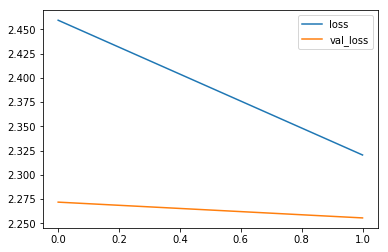

113218/113218 [==============================] - 833s 7ms/step - loss: 2.3205 - acc: 0.0000e+00 - val_loss: 2.2556 - val_acc: 0.0000e+00
Epoch 3/50
 45760/113218 [===========>..................] - ETA: 7:49 - loss: 2.2928 - acc: 0.0000e+00

KeyboardInterrupt: 

In [4]:
# SAFETY GUARD TO PREVENT FROM RUNNING BY MISTAKE
answer = input("Do you want to build and fit the model? ")
if answer != 'yes': sys.exit(0)

print('gpu name:',tf.test.gpu_device_name())
model_lstm = Sequential()

model_lstm.add(CuDNNGRU(100, input_shape=(4096,1), 
                        # regularizers.l1_l2(l1=0.01, l2=0.01), 
                        return_sequences=True))
model_lstm.add(CuDNNGRU(100,return_sequences=True))
model_lstm.add(CuDNNGRU(100))
# model_lstm.add(Dense(50, activation='relu'))
# model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(10, activation='relu'))
model_lstm.add(Dense(1, activation='linear'))

model_lstm.summary()

# Compile and fit model
model_lstm.compile(optimizer=Adam(lr=0.0005), loss="mae", 
                  # metrics=['accuracy']
                  )

# serialize model to JSON
model_json = model_lstm.to_json()
with open("./data/model/model-CuDNNGRU.json", "w") as json_file:
    json_file.write(model_json)

# checkpoint
# filepath="./data/train/weights3-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath="./data/model/weights-CuDNNGRU-improvement-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             # monitor='val_acc', 
                             verbose=1, save_best_only=True
                             #, mode='max'
                            )
callbacks_list = [checkpoint,
                 # plot_learning_loss,
                 plot_losses
                 ]
# Fit the model

history = model_lstm.fit( 
                            X_train, 
                            y_train, 
                            epochs = 50, 
                            validation_data = (X_test, y_test),
                            batch_size = 64,
                            callbacks=callbacks_list
                        )

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    # return None

perf_plot(history)

plt.savefig('./data/train.png')

# serialize weights to HDF5
model_lstm.save_weights("./data/model/model-CuDNNGRU_final_weights.h5")


In [ ]:
# SAFETY GUARD TO PREVENT FROM RUNNING BY MISTAKE
answer = input("Do you want to continue fitting with the loaded model and weights? ")
if answer != 'yes': sys.exit(0)

history = model_lstm.fit( 
                            X_train, 
                            y_train, 
                            epochs = 50, 
                            validation_data = (X_test, y_test),
                            batch_size = 64,
                            callbacks=callbacks_list
                        )


In [8]:
# SAFETY GUARD TO PREVENT FROM RUNNING BY MISTAKE
answer = input("Do you want to load a saved model and weights? ")
if answer != 'yes': sys.exit(0)

print('gpu name:',tf.test.gpu_device_name())

model_lstm = Sequential()

model_lstm.add(CuDNNGRU(100, input_shape=(4096,1), 
                        # regularizers.l1_l2(l1=0.01, l2=0.01), 
                        return_sequences=True))
model_lstm.add(CuDNNGRU(100,return_sequences=True))
model_lstm.add(CuDNNGRU(100))
# model_lstm.add(Dense(50, activation='relu'))
# model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(10, activation='relu'))
model_lstm.add(Dense(1, activation='linear'))

model_lstm.summary()

# Compile and fit model
model_lstm.compile(optimizer=Adam(lr=0.0005), loss="mae", 
                  # metrics=['accuracy']
                  )

model_lstm.load_weights('./data/model/weights-CuDNNGRU-improvement-16.hdf5')

# checkpoint
# filepath="./data/train/weights3-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath="./data/model/weights_reloaded-CuDNNGRU-improvement-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             # monitor='val_acc', 
                             verbose=1, save_best_only=True
                             #, mode='max'
                            )
callbacks_list = [checkpoint,
                  # plot_learning_loss,
                  plot_losses
                 ]
# Fit the model

history = model_lstm.fit( 
                            X_train, 
                            y_train, 
                            epochs = 2, 
                            validation_data = (X_test, y_test),
                            batch_size = 64,
                            # batch_size = 256,
                            callbacks=callbacks_list
                        )

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    # return None

perf_plot(history)

plt.savefig('./data/train.png')

# serialize model to JSON
model_json = model_lstm.to_json()
with open("./data/model/model_reloaded-CuDNNGRU.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_lstm.save_weights("./data/model/model_reloaded-CuDNNGRU_final_weights.h5")


Do you want to load a saved model and weights? yes
gpu name: /device:GPU:0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru (CuDNNGRU)         (None, 4096, 100)         30900     
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 4096, 100)         60600     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 100)               60600     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 153,121
Trainable params: 153,121
Non-trainable param

UnknownError: Fail to find the dnn implementation.
	 [[{{node cu_dnngru/CudnnRNN}} = CudnnRNN[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/cu_dnngru/CudnnRNN_grad/CudnnRNNBackprop"], direction="unidirectional", dropout=0, input_mode="linear_input", is_training=true, rnn_mode="gru", seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](cu_dnngru/transpose, cu_dnngru/ExpandDims, training/Adam/Const_27, cu_dnngru/concat)]]
	 [[{{node loss/dense_1_loss/broadcast_weights/assert_broadcastable/AssertGuard/Assert/Switch_3/_221}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_664_l...t/Switch_3", tensor_type=DT_BOOL, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.gridspec as gridspec

Y_test_hat = model_lstm.predict(X_train)

Y_test_hat = np.reshape(Y_test_hat, (1,np.product(Y_test_hat.shape)))

residuals = np.subtract(Y_test_hat,y_train)

print(Y_test_hat.shape, residuals.shape, y_train.shape)

figure, axes1 = plt.subplots(figsize=(18,10))

plt.scatter(y_train, residuals)
plt.xlabel("y_train")
plt.ylabel("Y_test_hat residuals")



In [ ]:
import matplotlib.gridspec as gridspec

Y_test_hat = model_lstm.predict(X_train)
y_test1 = np.reshape(y_train, (np.product(y_train.shape)))

Y_test_hat = np.reshape(Y_test_hat, (np.product(Y_test_hat.shape)))
residuals = np.subtract(Y_test_hat,y_test1)

print(Y_test_hat.shape, residuals.shape, y_test.shape)
figure, axes1 = plt.subplots(figsize=(18,10))
plt.hist2d(y_test1, residuals,100)
plt.xlabel("y_train")
plt.ylabel("Y_test_hat residuals")

